In [85]:
import numpy as np
import torch
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [86]:
class ToFU(torch.nn.Module):
    
    def __init__(self,n_features,birth_lims = [0,1]):
        super(ToFU,self).__init__()
        
        # initialize learnable diagram
        lwr_lim,upper_lim = birth_lims
        rng = upper_lim - lwr_lim
        b = torch.maximum(rng*torch.rand(n_features)+lwr_lim,torch.tensor(lwr_lim))
        d = b+(rng*torch.rand(n_features)+lwr_lim)
        dgm = torch.hstack((b.view(n_features,1),d.view(n_features,1)))
        
        self.dgm = torch.nn.Parameter(dgm)
        self.dgm_np = dgm.detach().cpu().numpy()
        
    def forward(self,dgm_x):
             
        # compute minimal cost matchings
        dgm_x_np = dgm_x.detach().cpu().numpy()
        cost = cdist(self.dgm_np, dgm_x_np)
        tofu_idx, target_idx = linear_sum_assignment(cost)
        
        # compute forward pass
        dgm_target = self.dgm.clone().detach()
        dgm_target[tofu_idx,:] = dgm_x[target_idx,:]
        
        return 0.5*((self.dgm-dgm_target)**2).sum()
        

In [87]:
# test initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = 5
birth_lims = [4,10]

tofu = ToFU(n_features,birth_lims).to(device)

print('Initial ToFU Diagram is:')
print(tofu.dgm)

print('The initial NumPy version of the ToFU Diagram is:')
print(tofu.dgm_np)

Initial ToFU Diagram is:
Parameter containing:
tensor([[ 5.3137, 10.3380],
        [ 7.0814, 12.8323],
        [ 6.1760, 13.4293],
        [ 7.3788, 15.8875],
        [ 4.2791, 10.8904]], device='cuda:0', requires_grad=True)
The initial NumPy version of the ToFU Diagram is:
[[ 5.313664  10.338018 ]
 [ 7.081412  12.8323   ]
 [ 6.1760235 13.429251 ]
 [ 7.378812  15.887507 ]
 [ 4.2791376 10.890403 ]]


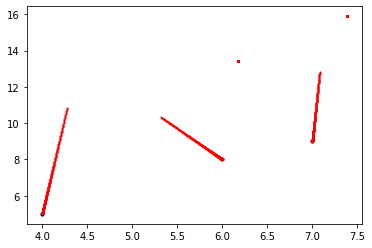

In [88]:
# test gradient computation
steps = 500
grad_steps = np.zeros((steps,n_features,2))

dgm_x = torch.tensor([[4.,5.],[6.,8.],[7.,9.]]).to(device)
dgm_x_np = dgm_x.detach().cpu().numpy()

opt = torch.optim.SGD(tofu.parameters(),lr = 1e-2)

for i in range(steps):
    L = tofu(dgm_x)
    L.backward()
    opt.step()
    opt.zero_grad()
    grad_steps[i,:,:] = tofu.dgm.detach().cpu().numpy() 

grad_steps = np.vstack(grad_steps)
plt.scatter(dgm_x_np[:,0],dgm_x_np[:,1],c = 'black',s = 10)
plt.scatter(grad_steps[:,0],grad_steps[:,1],c = 'red', s = 1)
plt.show()
plt.close()

In [123]:
class BatchToFU(torch.nn.Module):
    
    def __init__(self,n_features,device,birth_lims = [0,1]):
        super(BatchToFU,self).__init__()
        self.tofu = ToFU(n_features,birth_lims)
        self.device = device
        
    def forward(self,dgm_batch):
        h_batch = torch.zeros((dgm_batch.shape[0],1),requires_grad = True).to(self.device)
        
        for b_idx,dgm_x in enumerate(dgm_batch):
            h = self.tofu(dgm_x)
            h_batch[b_idx,:] = h
            
        return h_batch

In [124]:
# batch tofu forward pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = 3
birth_lims = [2,15]
dgm_batch = torch.tensor([[[4.,15.],[6.,18.],[7.,19.]],[[4.,5.],[6.,8.],[7.,9.]]]).to(device)

batch_tofu =  BatchToFU(n_features,device,birth_lims).to(device)
h_batch = batch_tofu(dgm_batch)

print('Hidden representations of batch elements are:')
print(h_batch)

Hidden representations of batch elements are:
tensor([[38.2143],
        [78.5218]], device='cuda:0', grad_fn=<CopySlices>)


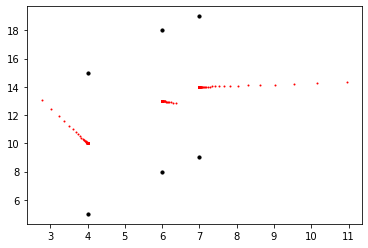

In [125]:
# test gradient computation over batches
steps = 1000
grad_steps = np.zeros((steps,n_features,2))

dgm_batch_np = dgm_batch.detach().cpu().numpy()
dgm_batch_np = np.vstack(dgm_batch_np)


opt = torch.optim.SGD(batch_tofu.parameters(),lr = 1e-1)

for i in range(steps):
    L = batch_tofu(dgm_batch)
    L.sum().backward()
    opt.step()
    opt.zero_grad()
    grad_steps[i,:,:] = batch_tofu.tofu.dgm.detach().cpu().numpy() 

grad_steps = np.vstack(grad_steps)
plt.scatter(dgm_batch_np[:,0],dgm_batch_np[:,1],c = 'black',s = 10)
plt.scatter(grad_steps[:,0],grad_steps[:,1],c = 'red', s = 1)
plt.show()
plt.close()

In [143]:
class ToFULayer(torch.nn.Module):
    
    def __init__(self,n_dgms,n_features,device,birth_lims = [0,1]):
        super(ToFULayer,self).__init__()
        self.n_dgms = n_dgms
        self.units = torch.nn.ModuleList([BatchToFU(n_features,device,birth_lims) for i in range(n_dgms)]) # (n_dgms,batch_size,1)
        
    def forward(self,dgm_batch):
        h = torch.zeros((self.n_dgms,dgm_batch.shape[0],1),requires_grad = True).to(device)
        
        for i,unit in enumerate(self.units):
            h[i,:,:] = unit(dgm_batch)
        
        h = torch.einsum('cbf -> bcf',h)
        return h.view(dgm_batch.shape[0],self.n_dgms)

In [144]:
# test layer forward pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_dgms,n_features = 5,3
birth_lims = [2,15]
dgm_batch = torch.tensor([[[4.,15.],[6.,18.],[7.,19.]],[[4.,5.],[6.,8.],[7.,9.]]]).to(device)
mod = ToFULayer(n_dgms,n_features,device,birth_lims).to(device)

h = mod(dgm_batch)